In [1]:
import sys
sys.path.append("../")

In [2]:
import alphatsp
import alphatsp.tsp
import alphatsp.util

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

In [5]:
import tqdm

In [6]:
import numpy as np

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
N, D = 20, 2

In [9]:
point_sampler = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))

In [10]:
def compute_tour_length(graph, tour):
    if isinstance(graph, torch_geometric.data.data.Data): points = graph.pos
    else: points = graph
    points = points[tour]
    diffs = np.diff(points, axis=0)
    tour_len = np.linalg.norm(diffs, axis=1, ord=2).sum()
    return tour_len

In [11]:
def greedy_solver(graph, selection_func, iterations=None, partial_tour=None):
    
    if isinstance(graph, torch_geometric.data.data.Data): points = graph.pos
    else: points = graph
    n, d = points.shape
    
    if partial_tour is None:
        tour = [0]
    else:
        tour = partial_tour
    
    remaining = list(set(range(n)) - set(tour))
    
    it = len(tour)
    while remaining:
        if iterations is not None and iterations <= it: break
        it += 1

        next_remaining = selection_func(graph, tour, remaining)
        next_node = remaining[next_remaining]
        
        tour.append(next_node)
        remaining = list(set(range(n)) - set(tour))
    
    if iterations is None:
        tour.append(tour[0])

    return tour

In [12]:
def nearest_selection(graph, tour, remaining):
    if isinstance(graph, torch_geometric.data.data.Data): points = graph.pos
    else: points = graph
    return torch.argmin(torch.norm(points[tour[-1]] - points[remaining], p=2, dim=1))

In [13]:
def nn_selection(graph, tour, remaining):
    choices = torch.tensor(sorted(remaining), dtype=torch.long)
    pred = policy_network(graph, choices)
    pred = torch.argmax(pred[0].squeeze())
    return pred

In [14]:
# generate random triplets of (graph, choices, best_choice)
# according to some selection function
def generate_example(n=10, d=2, selection_func=nearest_selection):
    
    points = point_sampler.sample((n, d)).squeeze().to(dtype=torch.float)
    iterations = np.random.randint(n-2)
    # TODO: weight the iteration selection so that examples with few iterations produced more
    
    tour = greedy_solver(points, selection_func, iterations=iterations)
    remaining = sorted(list(set(range(n)) - set(tour)))
    remaining = torch.tensor(remaining, dtype=torch.long)
    
    next_remaining = selection_func(points, tour, remaining)
    next_node = remaining[next_remaining]
    
    label = torch.zeros(len(remaining), dtype=torch.float)
    label[next_remaining] = 1
    
    y = torch.zeros(n, dtype=torch.float)
    y[next_node] = 1
    
    full_tour = greedy_solver(points, selection_func, partial_tour=tour)
    value = compute_tour_length(points, full_tour)
    value = torch.tensor(value)
    
    edges = torch.zeros((2, len(tour)-1), dtype=torch.long)
    for i in range(len(tour)-1):
        edges[0, i] = tour[i]
        edges[1, i] = tour[i+1]
    
    graph = Data(pos=points, edge_index=edges, y=y)
    
    return graph, remaining, label, value

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, n=10, d=2):
        super(PolicyNetwork, self).__init__()
        self.conv1 = GCNConv(d, 16)
        self.conv2 = GCNConv(16, 1)
        self.fc = nn.Linear(n, 1)
    
    def forward(self, graph, choices):
        x, edges = graph.pos, graph.edge_index
        
        x = self.conv1(x, edges)
        x = F.relu(x)
        x = self.conv2(x, edges)
        
        choice = x[choices]
        choice = F.softmax(choice, dim=0)
        
        value = self.fc(F.relu(x.squeeze()))

        return choice, value

In [32]:
policy_network = PolicyNetwork(n=N, d=D)

In [41]:
optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

In [42]:
def train(model, iterations=1000):
    losses = []
    policy_network.train()
    for _ in tqdm.tqdm(range(iterations)):
        graph, choices, next_node, value = generate_example(n=N, d=D)
        pred_choices, pred_value = model(graph, choices)
        loss = loss_func(pred_choices, next_node) + (0.2 * loss_func(pred_value, value))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, losses

In [43]:
policy_network, losses = train(policy_network, iterations=30000)

100%|██████████| 30000/30000 [01:07<00:00, 444.19it/s]


In [44]:
def test_tour(model):
    
    graph, choices, next_node, value = generate_example(n=N, d=D)
    
    tour_greedy = greedy_solver(graph, nearest_selection)
    tour_nn = greedy_solver(graph, nn_selection)
    
    tour_len_greedy = compute_tour_length(graph, tour_greedy)
    tour_len_nn = compute_tour_length(graph, tour_nn)
    
    return tour_greedy, tour_nn, tour_len_greedy, tour_len_nn

In [45]:
def test_value(model):
    graph, choices, next_node, value = generate_example(n=N, d=D)
    pred_value = model(graph, choices)[1]
    return value, pred_value

In [46]:
def test_tour_average(model, trials=200):
    
    greedy_lengths = torch.zeros(trials)
    nn_lengths = torch.zeros(trials)
    
    for i in tqdm.tqdm(range(trials)):
    
        graph, choices, next_node, value = generate_example(n=N, d=D)

        tour_greedy = greedy_solver(graph, nearest_selection)
        tour_nn = greedy_solver(graph, nn_selection)

        greedy_lengths[i] = torch.tensor(compute_tour_length(graph, tour_greedy))
        nn_lengths[i] = torch.tensor(compute_tour_length(graph, tour_nn))
        
    diffs = nn_lengths - greedy_lengths
    avg_diff = diffs.mean()
    percent_diff = (nn_lengths / greedy_lengths).mean()
    
    return avg_diff, percent_diff

In [47]:
def test_value_average(model, trials=200):
    
    true_values = torch.zeros(trials)
    pred_values = torch.zeros(trials)
    
    for i in tqdm.tqdm(range(trials)):
        
        graph, choices, next_node, value = generate_example(n=N, d=D)
        pred_value = model(graph, choices)[1]
        
        true_values[i] = value
        pred_values[i] = pred_value
        
    diffs = torch.abs(true_values - pred_values)
    
    print(true_values.mean(), true_values.std())
    
    avg_diff = diffs.mean()
    percent_diff = (diffs / torch.max(true_values, pred_values)).mean()
        
    return avg_diff, percent_diff

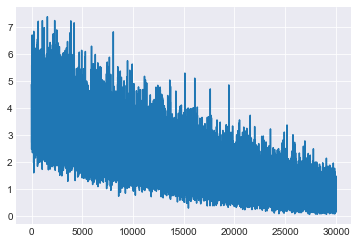

In [48]:
plt.plot(losses)
plt.show()

In [49]:
test_tour(policy_network)

([0, 9, 3, 14, 7, 18, 5, 11, 6, 2, 12, 10, 15, 17, 13, 4, 19, 16, 8, 1, 0],
 [0, 18, 11, 5, 7, 6, 2, 14, 1, 3, 9, 12, 17, 15, 10, 13, 16, 19, 4, 8, 0],
 4.0847597,
 7.821255)

In [50]:
test_value(policy_network)

(tensor(4.4656), tensor([2.9684], grad_fn=<AddBackward0>))

In [51]:
test_tour_average(policy_network, trials=1000)

100%|██████████| 1000/1000 [00:13<00:00, 73.09it/s]


(tensor(3.7079), tensor(1.8410))

In [52]:
test_value_average(policy_network, trials=1000)

100%|██████████| 1000/1000 [00:01<00:00, 555.79it/s]

tensor(4.5352) tensor(0.5506)


(tensor(1.5667, grad_fn=<MeanBackward1>),
 tensor(0.3357, grad_fn=<MeanBackward1>))